In [18]:
from __future__ import print_function
import warnings
warnings.simplefilter('ignore')

import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import copy

### Create dataset.

In [19]:
class ImagesLoader(Dataset):
    def __init__(self,path) -> None:
        self.path = path
        self.images = os.listdir(path)
        self.transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        ])        

    def __len__(self) -> int:
        return len(self.images)

    def init(self,stop=10000):
        imgs = []
        for idx,_ in enumerate(self.images[:stop]):
            img = self.images[idx % len(self.images)]
            image_path = os.path.join(self.path, img)
            img =  Image.open(image_path).convert('RGB')
            img = self.transform(img)
            imgs.append(img)
        return imgs

    def __getitem__(self, idx):
        img = self.images[idx % len(self.images)]
        image_path = os.path.join(self.path, img)
        img =  Image.open(image_path).convert('RGB')
        img = self.transform(img)
        return img
    

In [20]:
monet_data=ImagesLoader('../input/gan-getting-started/monet_jpg')
photo_data=ImagesLoader('../input/gan-getting-started/photo_jpg')

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
images = monet_data.init()
monets = torch.stack(images)


# images = photo_data.init()
# photo_data = torch.stack(images)

In [23]:
print(monets.shape)

torch.Size([300, 3, 256, 256])


## Condensating data set by augmentation. 

torch.Size([600, 3, 256, 256])


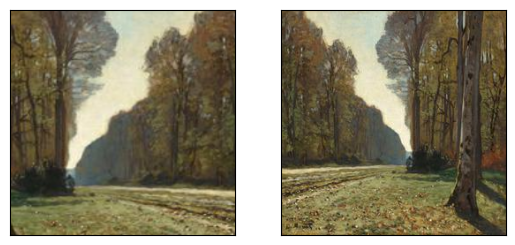

In [24]:
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transforms_crop = torch.nn.Sequential(
    T.RandomResizedCrop(256,(0.1,0.7)),
    T.RandomHorizontalFlip(p=0.2),
)
transform_flip=torch.nn.Sequential(
    T.RandomResizedCrop(256,(0.90,1)),
    T.RandomHorizontalFlip(p=0.2),
)
monets=monets.to(device)
def augment():
    return torch.cat((transforms_crop(monets),transform_flip(monets)),0)

transformed=augment()
print(transformed.shape)
show([transformed[2], monets[2]])
monet_train=torch.cat((monets,transformed),0)


In [25]:
class TrainDataset(Dataset):
    def __init__(self, monet_ds, photo_ds):
        self.monet_ds = monet_ds
        self.photo_ds = photo_ds
        
    def __len__(self):
        return max(len(self.monet_ds), len(self.photo_ds))

    def __getitem__(self, idx):
        monet_idx = idx % len(self.monet_ds)
        photo_idx = idx % len(self.photo_ds)
    
        monet_img = self.monet_ds[monet_idx]
        photo_img = self.photo_ds[photo_idx]
        
        return monet_img, photo_img

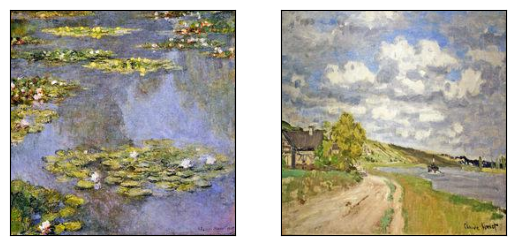

In [26]:
show(monet_train[:2])

train_dataset=TrainDataset(monet_train,photo_data)

In [27]:
monet_img, photo_img = train_dataset.__getitem__(0)
print(monet_img.shape)
print(photo_img.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [28]:
imsize = 256 #512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor()]) 

to_pil = T.ToPILImage()

def image_loader(image):
    # convert the tensor to PIL image using above transform
    image = to_pil(image)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# define a transform to convert a tensor to PIL image
to_pil = T.ToPILImage()
# convert the tensor to PIL image using above transform
img = to_pil(monet_train[3])
# display the PIL image

style_img = image_loader(monet_train[3])
content_img = image_loader(photo_data[3])

print(style_img.size())
print(style_img.size())
content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"



torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


## Blocks

In [29]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(f, f, 3, 1, 1), 
            nn.InstanceNorm2d(f),
            nn.ReLU(),
            
            nn.Conv2d(f, f, 3, 1, 1),
        )
        
        self.norm = nn.InstanceNorm2d(f)
        
    def forward(self, x):
        return torch.relu(self.conv(x) + x)
    

## Generator

In [30]:
class Generator(nn.Module):
    def __init__(self, f=64, res_blocks=6):
        super(Generator, self).__init__()
        layers = []
            
        layers.extend([
            nn.Conv2d(3, f, 7, 1, 3),
            nn.InstanceNorm2d(f), 
            nn.ReLU(True),

            nn.Conv2d(f, f * 2, 3, 2, 1),
            nn.InstanceNorm2d(f * 2),
            nn.ReLU(True),

            nn.Conv2d(f * 2, f * 4, 3, 2, 1),
            nn.InstanceNorm2d(f * 4),
            nn.ReLU(True)
        ])
            
        for i in range(res_blocks):
            layers.append(ResBlock(f * 4))
        
        layers.extend([
            nn.ConvTranspose2d(f * 4, f * 2 * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(f * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(f * 2, f * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(f),
            nn.ReLU(True),
    
            nn.ReflectionPad2d(3),
            nn.Conv2d(f, 3, 7, 1, 0),
            nn.Tanh()
            
        ])
         
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

## Discriminator

In [31]:
import torch.nn.functional as F
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=1, padding=1)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = self.conv5(x)
        return x


In [32]:
disc_M = Discriminator().to(device)
disc_P = Discriminator().to(device)

gen_M = Generator().to(device)
gen_P = Generator().to(device)

opt_disc = torch.optim.Adam(
    list(disc_M.parameters()) + list(disc_P.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

opt_gen = torch.optim.Adam(
    list(gen_M.parameters()) + list(gen_P.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

l1 = nn.L1Loss()
mse = nn.MSELoss()
loader = DataLoader(train_dataset , batch_size=1, shuffle=True)

In [33]:
num_epochs = 1
D_loss_arr=[]
G_loss_arr=[]

for epoch in range(num_epochs):
    loop = tqdm(loader, leave=True)
    
    for idx, (monet, photo) in enumerate(loop):
        #limit beacuse we have no gpu 
        monet = monet.to(device)
        photo = photo.to(device)
#         print("monet ",monet.shape)
#         print("photo ",photo.shape)
        fake_photo = gen_P(monet)
#         print("fake_photo",fake_photo.shape)
        D_P_real = disc_P(photo)
#         print("D_P_real",D_P_real.shape)
        D_P_fake = disc_P(fake_photo.detach())
#         print("D_P_fake",D_P_fake.shape)
        D_P_real_loss = mse(D_P_real, torch.ones(len(D_P_real)).to(device))
#         print("D_P_real_loss",D_P_real_loss.shape)
        D_P_fake_loss = mse(D_P_fake, torch.zeros(len(D_P_fake)).to(device))
#         print("D_P_fake_loss",D_P_fake_loss.shape)
        D_P_loss = D_P_real_loss + D_P_fake_loss

        fake_monet = gen_M(photo)
#         print("fake_monet",fake_monet.shape)
        D_M_real = disc_M(monet)
#         print("D_M_real",D_M_real.shape)
        D_M_fake = disc_M(fake_monet.detach())
#         print("D_M_fake",D_M_fake.shape)
        D_M_real_loss = mse(D_M_real, torch.ones(len(D_M_real)).to(device))     
        #pdb.set_trace()
        D_M_fake_loss = mse(D_M_fake, torch.zeros(len(D_M_fake)).to(device))
        D_M_loss = D_M_real_loss + D_M_fake_loss

        D_loss = (D_P_loss + D_M_loss) / 2
        D_loss_arr.append(D_loss.item())
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        D_P_fake = disc_P(fake_photo)
        D_M_fake = disc_M(fake_monet)
        loss_G_P = mse(D_P_fake, torch.ones(len(D_P_fake)).to(device))
        loss_G_M = mse(D_M_fake, torch.ones(len(D_M_fake)).to(device))

        cycle_photo = gen_P(fake_monet)
        cycle_monet = gen_M(fake_photo)
        cycle_photo_loss = l1(photo, cycle_photo)
        cycle_monet_loss = l1(monet, cycle_monet)

        identity_photo = gen_P(photo)
        identity_monet = gen_M(monet)
        identity_photo_loss = l1(photo, identity_photo)
        identity_monet_loss = l1(monet, identity_monet)

        G_loss = (
            loss_G_P 
            + loss_G_M 
            + cycle_photo_loss * 10
            + cycle_monet_loss * 10
             + identity_photo_loss
            + identity_monet_loss
        )
        G_loss_arr.append(G_loss.item())
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        
        if idx % 2000 == 0:
            print(
                'G_P_loss:', loss_G_P.cpu().detach().item(), 
                'G_M_loss:', loss_G_M.cpu().detach().item(), 
                'D_M_loss:', D_M_loss.cpu().detach().item(), 
                'D_P_loss:', D_P_loss.cpu().detach().item()
            )
            print(f"G_loss {idx} = ",G_loss)
            print(f"D_loss {idx} = ",D_loss)
    print(f"Final epoch {epoch} G_loss {idx} = ",G_loss)
    print(f"Final epoch {epoch} D_loss {idx} = ",D_loss)

  0%|          | 1/7038 [00:01<2:51:58,  1.47s/it]

G_P_loss: 0.8288351893424988 G_M_loss: 0.8190647959709167 D_M_loss: 0.9711885452270508 D_P_loss: 0.9964331388473511
G_loss 0 =  tensor(12.1063, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 0 =  tensor(0.9838, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 2002/7038 [08:39<21:02,  3.99it/s]

G_P_loss: 0.4346761703491211 G_M_loss: 0.32241198420524597 D_M_loss: 0.35268086194992065 D_P_loss: 0.3351489007472992
G_loss 2000 =  tensor(3.1617, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 2000 =  tensor(0.3439, device='cuda:0', grad_fn=<DivBackward0>)


 57%|█████▋    | 4002/7038 [17:16<12:39,  4.00it/s]

G_P_loss: 0.7020420432090759 G_M_loss: 0.4022026062011719 D_M_loss: 0.4319012463092804 D_P_loss: 0.17584781348705292
G_loss 4000 =  tensor(3.3415, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 4000 =  tensor(0.3039, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 6002/7038 [25:54<04:20,  3.98it/s]

G_P_loss: 0.45451250672340393 G_M_loss: 0.2120712399482727 D_M_loss: 0.634023904800415 D_P_loss: 0.496774822473526
G_loss 6000 =  tensor(3.3279, device='cuda:0', grad_fn=<AddBackward0>)
D_loss 6000 =  tensor(0.5654, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 7038/7038 [30:22<00:00,  3.86it/s]

Final epoch 0 G_loss 7037 =  tensor(2.4849, device='cuda:0', grad_fn=<AddBackward0>)
Final epoch 0 D_loss 7037 =  tensor(0.3656, device='cuda:0', grad_fn=<DivBackward0>)


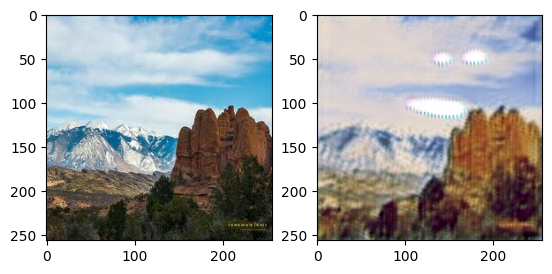

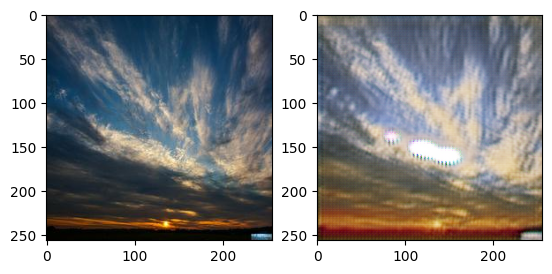

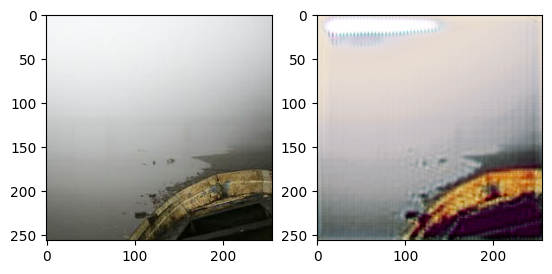

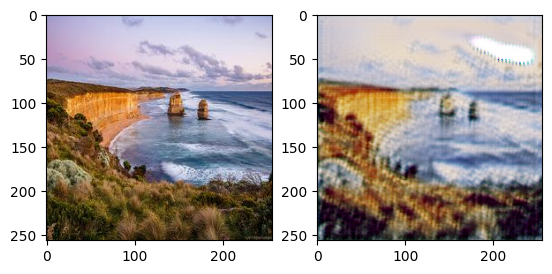

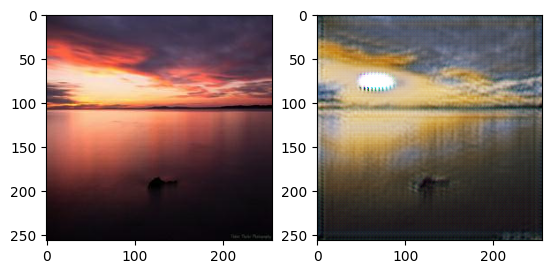

In [38]:
for idx, (monet, photo) in enumerate(loader):
    monet = monet.to(device)
    photo = photo.to(device)
    fake_photo = gen_P(monet)
    fake_monet = gen_M(photo).cpu().detach()[0]
    
    plt.subplot(121)
    plt.imshow(photo.cpu().detach()[0].squeeze().permute(1, 2, 0) )
    plt.subplot(122)
    plt.imshow(fake_monet.squeeze().permute(1, 2, 0) )
        
    plt.show()
    if idx == 4:
        break

In [61]:
import PIL
! mkdir ./images

In [62]:
photo_data=ImagesLoader('../input/gan-getting-started/photo_jpg')
import PIL
i = 1
print(len(train_dataset))
for photo in tqdm(photo_data):
    
    photo = photo.to(device)
    prediction = gen_M(photo[None, :]).cpu().detach()[0]
    prediction = ( prediction).permute(1, 2, 0).numpy().astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
    i+=1
    if i == 7038:
        break

7038


100%|█████████▉| 7036/7038 [01:56<00:00, 60.19it/s]


In [63]:
import shutil
shutil.make_archive('/kaggle/working/images', 'zip', '/kaggle/working/images')

'/kaggle/working/images.zip'